In [1]:
import sys
sys.path.append("/home/gonzalo/sw/git/Jupytools/")
sys.path.append("/home/gonzalo/sw/git/resin/python/")

from collections import defaultdict
from path import Path
from time import time

import numpy  as np
import polars as pl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from dataset import DS
from arch import *

from nbtools import auto_plot_style
from pltools import normhist

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

auto_plot_style()

In [3]:
folder = Path("/home/gonzalo/data/NEXT/resin/16x16/single_point/full_chamber/")
filenames = folder.glob("*.parquet")
len(filenames)

100

# Data quality check

In [4]:
filename = filenames[1]
df       = pl.read_parquet(filename)
pos      = df.select(list("xy"))
response = df.select(pl.col("^sipm.*$"))
df.head()

x,y,xabs,yabs,sipm_0,sipm_1,sipm_2,sipm_3,sipm_4,sipm_5,sipm_6,sipm_7,sipm_8,sipm_9,sipm_10,sipm_11,sipm_12,sipm_13,sipm_14,sipm_15,sipm_16,sipm_17,sipm_18,sipm_19,sipm_20,sipm_21,sipm_22,sipm_23,sipm_24,sipm_25,sipm_26,sipm_27,sipm_28,sipm_29,sipm_30,sipm_31,sipm_32,…,sipm_219,sipm_220,sipm_221,sipm_222,sipm_223,sipm_224,sipm_225,sipm_226,sipm_227,sipm_228,sipm_229,sipm_230,sipm_231,sipm_232,sipm_233,sipm_234,sipm_235,sipm_236,sipm_237,sipm_238,sipm_239,sipm_240,sipm_241,sipm_242,sipm_243,sipm_244,sipm_245,sipm_246,sipm_247,sipm_248,sipm_249,sipm_250,sipm_251,sipm_252,sipm_253,sipm_254,sipm_255
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.265331,1.894079,-122.265331,-118.105921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000282,0.000224,0.000177,0.000139,0.0,…,0.000428,0.000337,0.000261,0.000201,0.000155,0.0,0.000146,0.000182,0.000225,0.000275,0.000326,0.000372,0.000401,0.000406,0.000385,0.000345,0.000295,0.000244,0.000198,0.000159,0.000127,0.0,0.000117,0.000141,0.000169,0.000198,0.000227,0.000251,0.000266,0.000269,0.000258,0.000237,0.000209,0.00018,0.000151,0.000125,0.000104
3.441567,-2.92479,-16.558433,-32.92479,0.000103,0.000124,0.000149,0.000176,0.000204,0.00023,0.000249,0.000257,0.000254,0.000239,0.000215,0.000188,0.00016,0.000134,0.000111,0.000092,0.000127,0.000158,0.000196,0.00024,0.000288,0.000334,0.00037,0.000386,0.000379,0.00035,0.000307,0.000259,0.000213,0.000173,0.000139,0.000112,0.000156,…,0.000472,0.000356,0.000266,0.000201,0.000153,0.000146,0.000186,0.000237,0.0003,0.000371,0.000443,0.000502,0.00053,0.000518,0.00047,0.000401,0.000328,0.000262,0.000206,0.000162,0.000127,0.000119,0.000146,0.000179,0.000217,0.000258,0.000296,0.000325,0.000338,0.000333,0.000309,0.000274,0.000234,0.000195,0.000159,0.00013,0.000105
-0.399724,4.478842,59.600276,124.478842,0.000096,0.000118,0.000143,0.000173,0.000207,0.000241,0.000271,0.000292,0.000299,0.00029,0.000268,0.000237,0.000203,0.00017,0.00014,0.000115,0.000116,0.000146,0.000184,0.000231,0.000286,0.000347,0.000404,0.000445,0.000459,0.000442,0.000398,0.00034,0.00028,0.000225,0.000179,0.000142,0.000139,…,0.000489,0.0,0.0,0.0,0.0,0.000114,0.000143,0.00018,0.000225,0.000279,0.000336,0.00039,0.000429,0.000443,0.000426,0.000385,0.00033,0.0,0.0,0.0,0.0,0.000095,0.000116,0.000141,0.00017,0.000202,0.000234,0.000263,0.000283,0.00029,0.000281,0.00026,0.0,0.0,0.0,0.0,0.0
3.62079,4.163376,-66.37921,64.163376,0.00009,0.000108,0.000131,0.000156,0.000184,0.000211,0.000235,0.000251,0.000256,0.000249,0.000231,0.000206,0.000179,0.000152,0.000127,0.000105,0.000108,0.000135,0.000167,0.000207,0.000252,0.0003,0.000343,0.000374,0.000384,0.00037,0.000336,0.000292,0.000244,0.0002,0.000161,0.00013,0.00013,…,0.000575,0.000438,0.000329,0.000246,0.000186,0.000124,0.000157,0.000201,0.000255,0.000322,0.000395,0.000466,0.000518,0.000535,0.000511,0.000455,0.000383,0.00031,0.000245,0.000193,0.000151,0.000103,0.000127,0.000156,0.000191,0.00023,0.000271,0.000308,0.000333,0.000341,0.00033,0.000302,0.000264,0.000224,0.000185,0.000151,0.000122
4.66862,2.375922,-15.33138,-157.624078,0.0,0.0,0.0,0.0,0.0,0.0,0.000229,0.000243,0.000245,0.000237,0.000219,0.000195,0.000169,0.000143,0.00012,0.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.000335,0.000361,0.000366,0.00035,0.000316,0.000273,0.000228,0.000187,0.000151,0.000122,0.0,…,0.000573,0.000432,0.000321,0.00024,0.00018,0.0,0.0,0.0,0.0,0.0,0.000426,0.0005,0.000551,0.000562,0.000529,0.000463,0.000384,0.000308,0.000242,0.000189,0.000148,0.0,0.0,0.0,0.0,0.0,0.000289,0.000326,0.000351,0.000356,0.00034,0.000308,0.000267,0.000223,0.000184,0.000149,0.000121


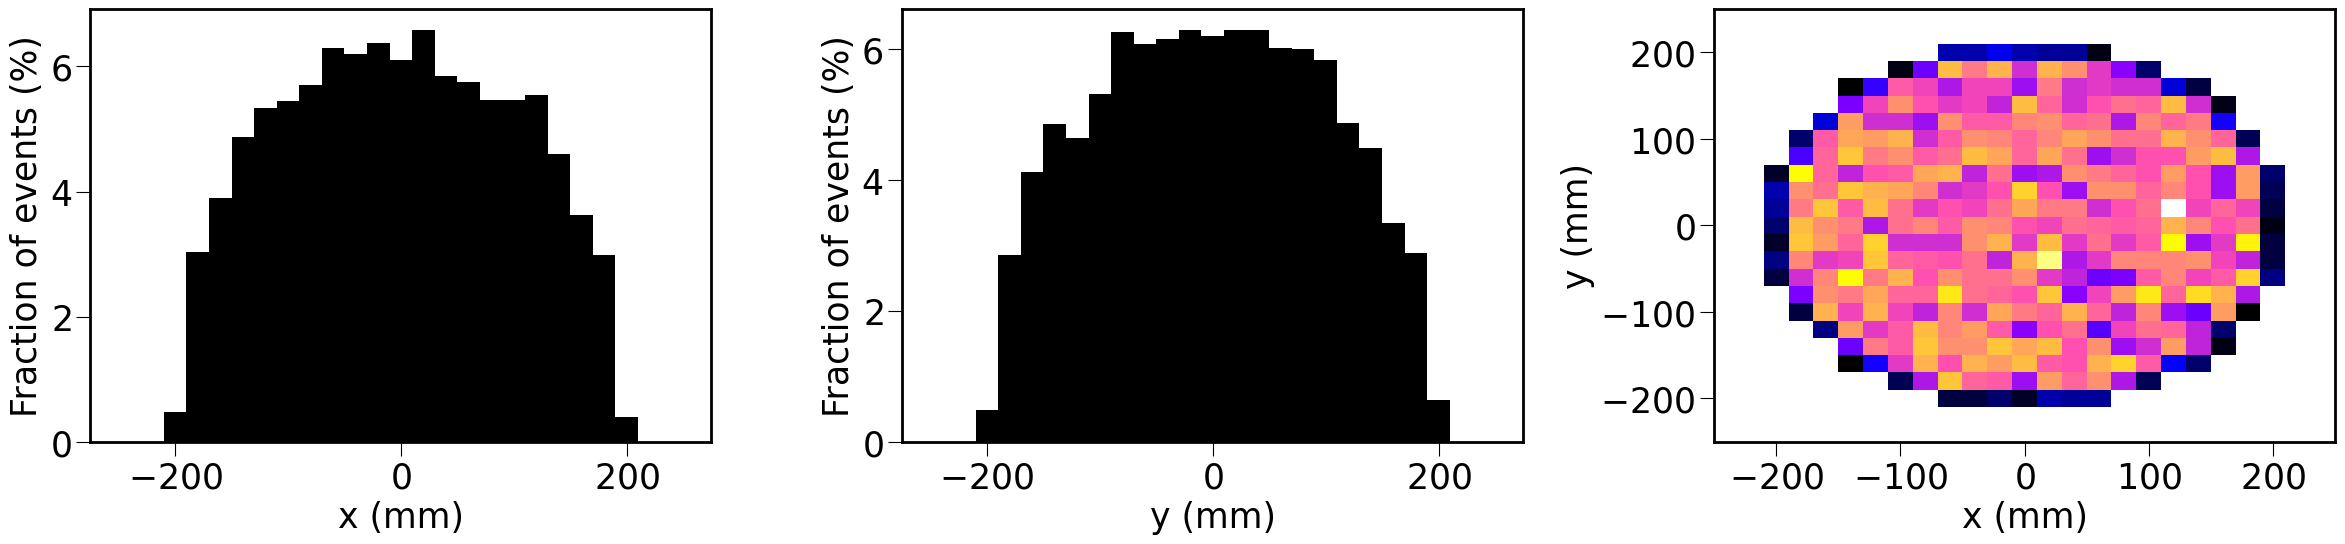

In [5]:
x = df.get_column("xabs")
y = df.get_column("yabs")

bins_xy = np.linspace(-250, 250, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

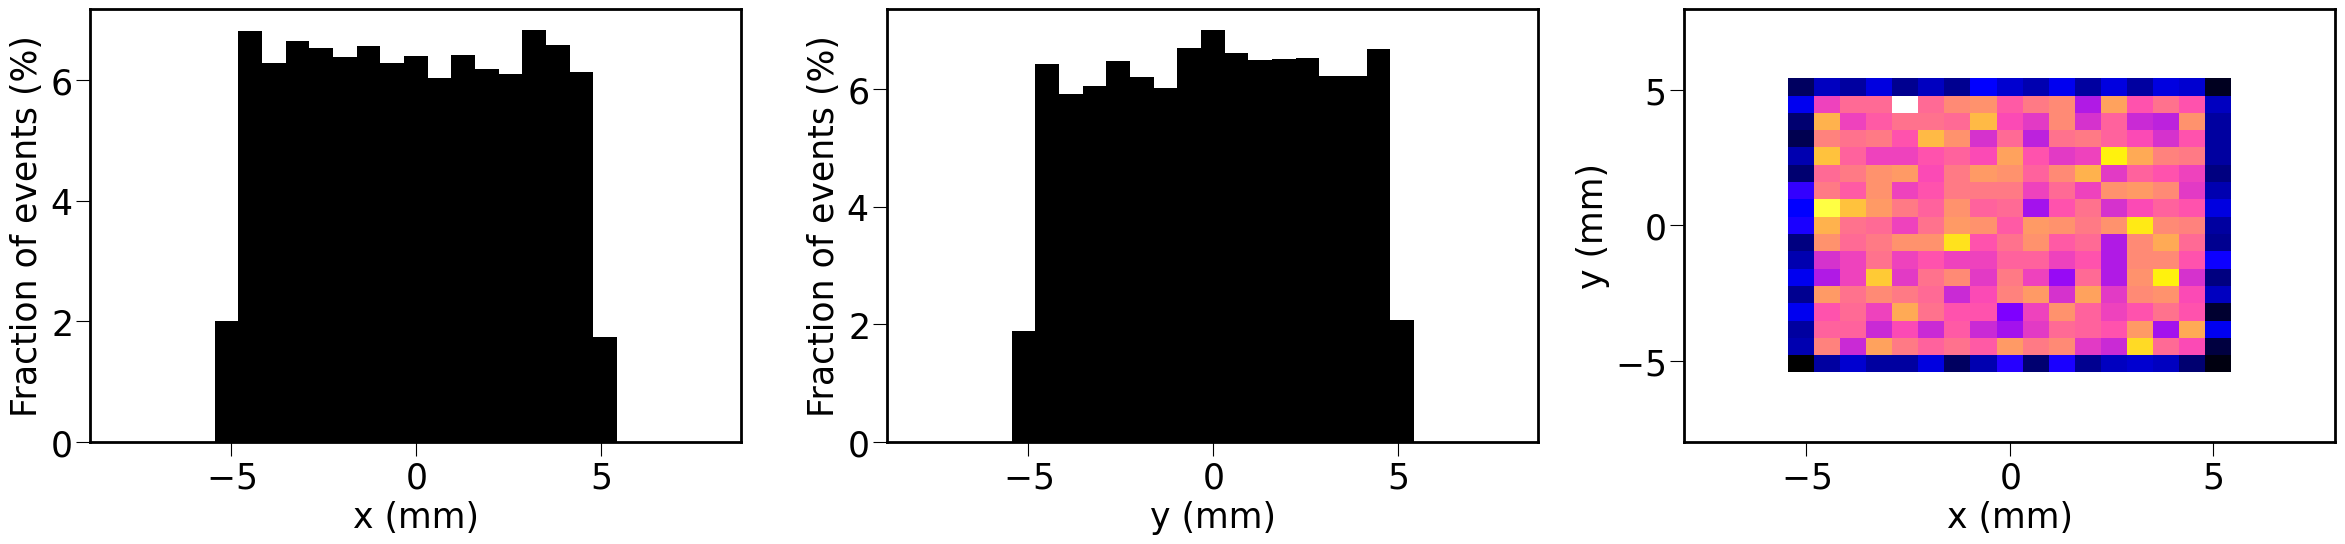

In [6]:
x = df.get_column("x")
y = df.get_column("y")

bins_xy = np.linspace(-8, 8, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

16


Text(0, 0.5, 'y (mm)')

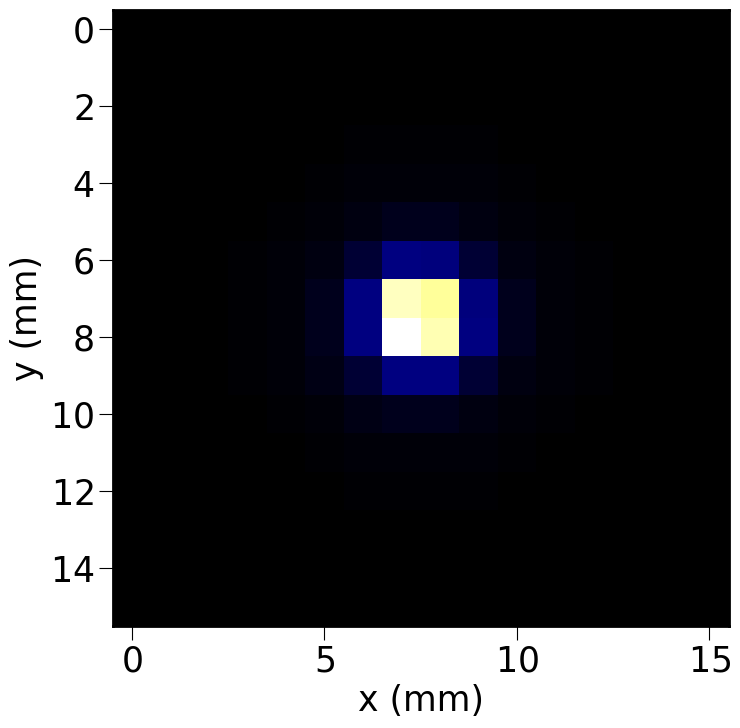

In [7]:
n   = int(response.width**0.5)
print(n)
img = response.sum().to_numpy().reshape(n, n).T
plt.imshow(img); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

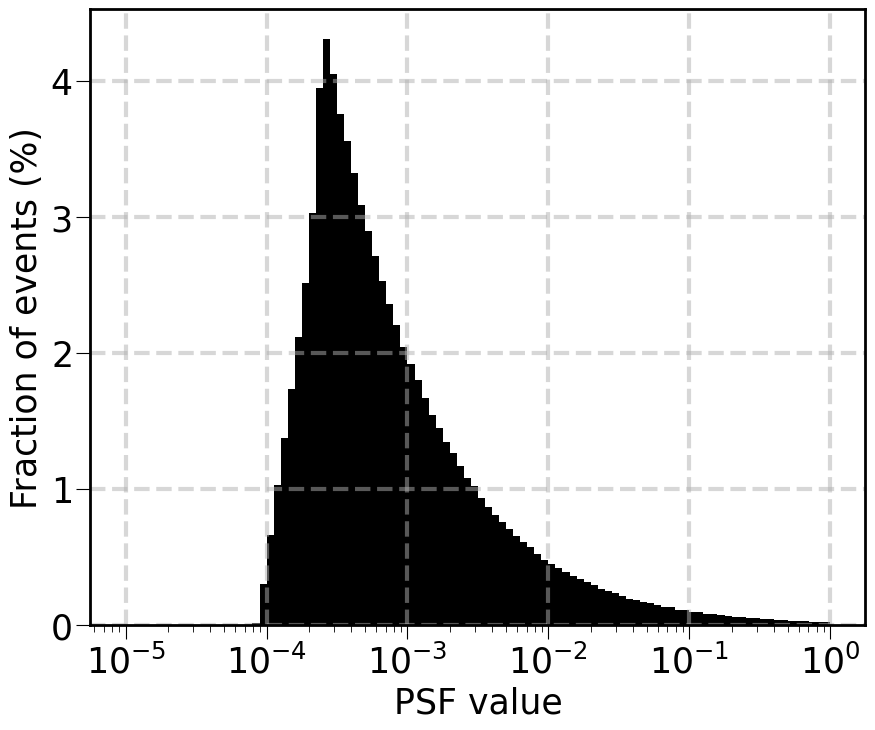

In [8]:
data = np.concatenate([s.to_numpy() for s in response.get_columns()])
normhist(data, np.logspace(-5, 0, 101))
plt.xscale("log")
plt.xlabel("PSF value")
plt.ylabel("Fraction of events (%)")
plt.grid()

# Net

## Data loading

In [9]:
f_train = 80
f_valid = 10
assert f_train + f_valid < 100

In [10]:
ds = DS(folder, 100)

idx_train, idx_valid, idx_test = ds.indices(f_train, f_valid)

ds_train = Subset(ds, idx_train); print(f"Training   data: {len(ds_train):>6d}")
ds_valid = Subset(ds, idx_valid); print(f"Validation data: {len(ds_valid):>6d}")
ds_test  = Subset(ds, idx_test ); print(f"Testing    data: {len(ds_test) :>6d}")

loader_train = DataLoader(ds_train, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_valid = DataLoader(ds_valid, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_test  = DataLoader(ds_test , batch_size=min(1000, ds.n_per_file), shuffle=False)

Training   data: 800000
Validation data: 100000
Testing    data: 100000


## Training

##### Sensible trainings
- linear v0 seed = 15945278987002563668 nfiles =  10 lr = 1e-4 nepochs = 20
- linear v0 seed = 16896108185643863306 nfiles = 100 lr = 1e-5 nepochs = 30
- linear v0 seed =  2989494183513620518 nfiles =  10 lr = 1e-4 nepochs = 50
- linear v1 seed =  1802610105865725067 nfiles = 100 lr = 1e-5 nepochs = 20

In [11]:
#torch.manual_seed(1234567890)
print("seed =", torch.seed())
nsipms_side = 16
nsipms      = nsipms_side**2
lr          = 1e-5
nepochs     = 20
nout        = 1
NN          = NN_linear_v1
model       = NN(nsipms, nout)
lossf       = nn.MSELoss()
optimizer   = optim.Adam(model.parameters(), lr=lr)
losses      = defaultdict(list)

for epoch in range(1, 1+nepochs):
    t0 = time()
    model.train() # inform the model that we are training
    optimizer.zero_grad()
    for i, (pos, response) in enumerate(loader_train, start=1):
        prediction = model(response)
        loss       = lossf(prediction, pos)
        loss     .backward()
        optimizer.step()

        losses[epoch].append(loss.data.item())
        
    validation_loss = []
    with torch.no_grad():
        model.eval() # tell the model that we are evaluating
        for i, (pos, response) in enumerate(loader_valid, start=1):
            prediction = model(response)
            loss       = lossf(prediction, pos)
            validation_loss.append(loss.data.item())
            
    dt = time() - t0
    print(f"Epoch [{epoch}/{nepochs}], Loss: {losses[epoch][-1]:.4f}, Val loss: {np.mean(validation_loss):.1f}, LR: {lr : .4f} DT : {dt:.1f}")
    #lr = max(0.75 * lr, 1e-4)

seed = 8939805052182571576
Epoch [1/20], Loss: 7.9001, Val loss: 7.9, LR:  0.0000 DT : 60.5
Epoch [2/20], Loss: 7.0852, Val loss: 7.0, LR:  0.0000 DT : 59.1
Epoch [3/20], Loss: 5.8802, Val loss: 5.8, LR:  0.0000 DT : 59.5
Epoch [4/20], Loss: 4.5489, Val loss: 4.5, LR:  0.0000 DT : 70.5
Epoch [5/20], Loss: 3.1993, Val loss: 3.2, LR:  0.0000 DT : 69.8
Epoch [6/20], Loss: 2.0191, Val loss: 2.0, LR:  0.0000 DT : 70.0
Epoch [7/20], Loss: 1.1446, Val loss: 1.2, LR:  0.0000 DT : 70.0
Epoch [8/20], Loss: 0.6274, Val loss: 0.6, LR:  0.0000 DT : 69.0
Epoch [9/20], Loss: 0.4206, Val loss: 0.4, LR:  0.0000 DT : 70.0
Epoch [10/20], Loss: 0.3738, Val loss: 0.4, LR:  0.0000 DT : 69.9
Epoch [11/20], Loss: 0.3513, Val loss: 0.4, LR:  0.0000 DT : 70.2
Epoch [12/20], Loss: 0.3335, Val loss: 0.4, LR:  0.0000 DT : 69.3
Epoch [13/20], Loss: 0.3196, Val loss: 0.3, LR:  0.0000 DT : 70.0
Epoch [14/20], Loss: 0.3243, Val loss: 0.3, LR:  0.0000 DT : 71.0
Epoch [15/20], Loss: 0.3905, Val loss: 0.4, LR:  0.0000 DT

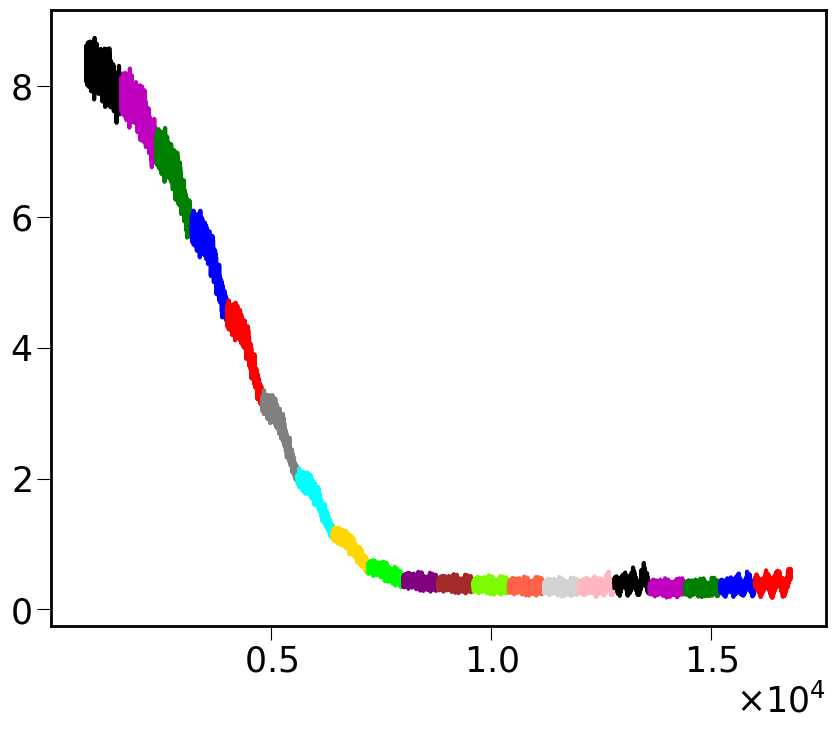

In [12]:
for ie, ep in sorted(losses.items()):
    plt.plot(np.arange(len(ep))+ie*len(ep), ep)

## Testing

In [13]:
dxs, dys, dps, ps = [[] for i in range(4)]
with torch.no_grad():
    model.eval()
    for pos, response in loader_test:
        predicted = model(response)
        dx, dy    = (predicted - pos).numpy().T
        dxs.extend(dx)
        dys.extend(dy)
        dps.extend((dx**2 + dy**2)**0.5)
        ps.extend((pos**2).sum(axis=1)**0.5)

In [14]:
true_pos, response = next(iter(loader_test))
model.eval()
predicted  = model(response[:1])
for axis, t, p in zip("xy", true_pos[0], predicted[0]):
    print(axis, t, p)

x tensor(2.0792, dtype=torch.float64) tensor(1.9931, dtype=torch.float64, grad_fn=<UnbindBackward0>)
y tensor(3.3455, dtype=torch.float64) tensor(2.9204, dtype=torch.float64, grad_fn=<UnbindBackward0>)


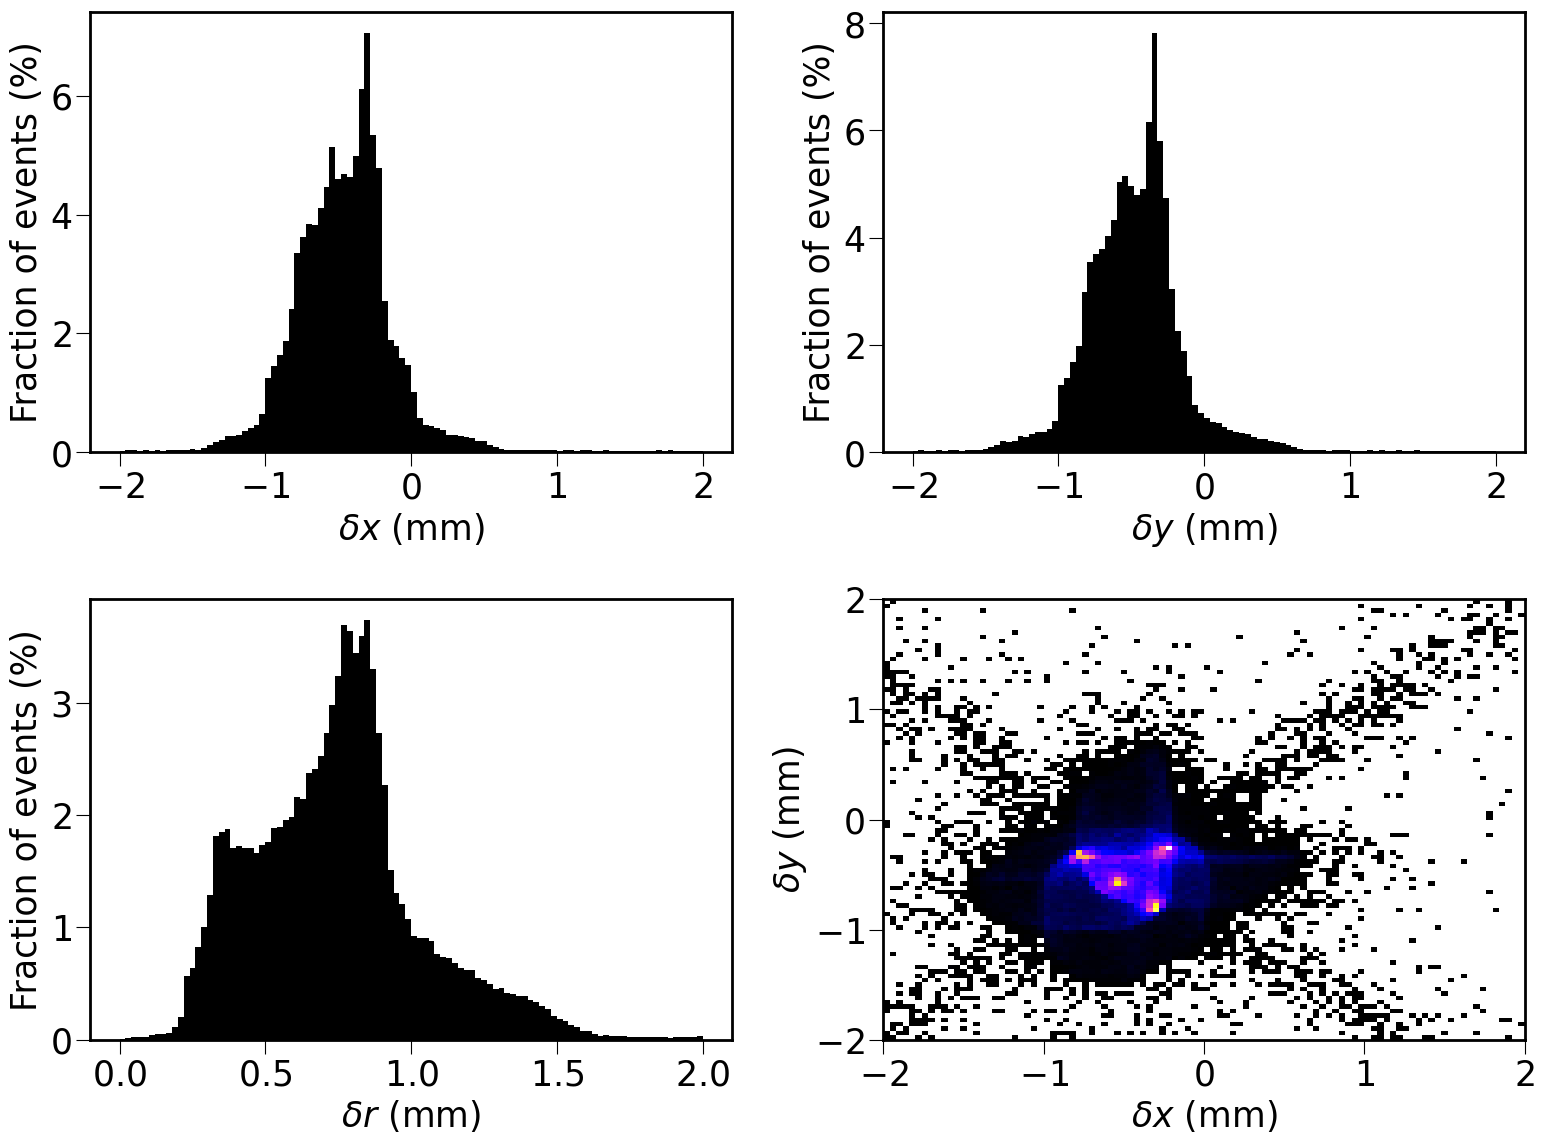

In [15]:
bins_dxy = np.linspace(-2, 2, 101)
bins_dr  = np.linspace( 0, 2, 101)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1); normhist(dxs, bins_dxy); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 2); normhist(dys, bins_dxy); plt.xlabel("$\delta y$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 3); normhist(dps, bins_dr ); plt.xlabel("$\delta r$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 4); plt.hist2d(dxs, dys, (bins_dxy,)*2, cmin=1); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("$\delta y$ (mm)")

plt.tight_layout()

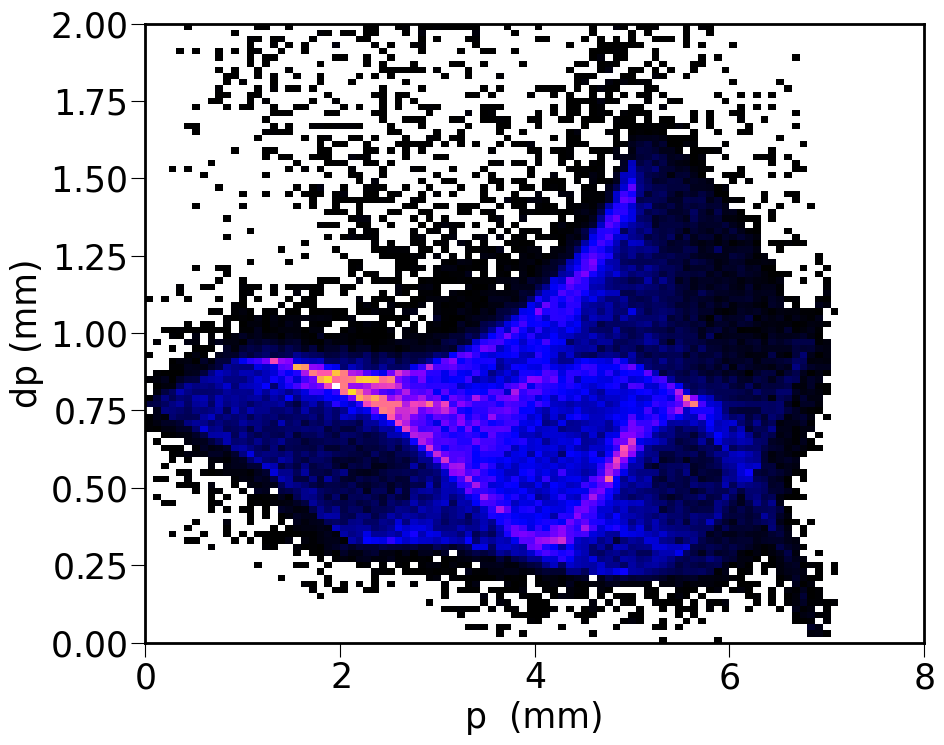

In [16]:
bins_r = np.linspace(0, bins_xy.max(), 101)
plt.hist2d(ps, dps, (bins_r, bins_dr), cmin=1)
plt.xlabel("p  (mm)")
plt.ylabel("dp (mm)")

plt.tight_layout()